# 배경

- 책 <빅데이터 분석(1)> 198p 참고, 

- 미세먼지 발생/증가에 영향을 미치는 인자를 도출, 영향도를 분석
- 선정된 영향인자를 활용하여 미세먼지 발생량 예측, 대응방안 수립. 

# 내가 생각한 흐름


- 목표변수: 미세먼지 발생량 (PM10)


- 나머지는 다 설명변수(날짜 제외) 
- 대기오염인자(이산화탄소 농도, 아황산가스 농도, 이산화질소농도) 높을수록 미세먼지 높음
- 기상정보- 기온, 습도와 반비례
- 기상정보 - 기압과 비례
- 고려대상: 오존농도? 관련성 있는가? **-> 상관분석? **
- 고려대상: 계절성- 겨울 높고 여름 낮음 


- 예측모델의 특징을 이해, 모델의 성능개선방안 도출
- **분석기법**: 탐색적분석(그래프, 통계), 회귀분석(선형, 규제모델), 의사결정트리, 랜덤포레스트, 그래디언트부스팅



## 주의할 것
- 각 칼럼의 단위가 모두 다르기에 스케일링을 해주어야 한다. 

## 파생변수 만들기?

- 계절성: 날짜를 월만 받아와서 월 평균을 낸다.   
    3,4,5-> 봄, 6,7,8-> 여름, 9,10,11-> 가을 12,1,2-> 겨울

### 패키지 불러오기

In [1]:
# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 데이터 scaling
from sklearn.preprocessing import StandardScaler, RobustScaler

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro

# 회귀 분석
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
import statsmodels.api as sm


# 의사결정 나무
from sklearn.tree import DecisionTreeRegressor

# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor

# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor

# 로지스틱 회귀
from statsmodels.api import Logit

# 의사결정 나무
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier

# 분류 SVM
from sklearn.svm import SVC

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#경고무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
#한글폰트

matplotlib.rc('font', family = 'Malgun Gothic')

# EDA

### 데이터 불러오기

In [3]:
df_raw = pd.read_csv("AIR_POLLUTION.csv", parse_dates = ["MeasDate"])
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [4]:
df_raw.tail()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,24.06,1.26,2.48,103,75.5,992.9,0.0,7.58
365,2020-06-30,6.0,0.039,0.009,0.3,0.002,20.60,5.60,4.00,50,92.0,983.8,0.0,10.00


In [5]:
df_raw.shape

(366, 14)

- 해당 데이터 셋은 2019년 7월 1일부터 2020년 6월 30일까지 총 1년간의 데이터임을 알 수 있다. 

In [6]:
#데이터 속성 확인하기

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   MeasDate   366 non-null    datetime64[ns]
 1   PM10       365 non-null    float64       
 2   O3         365 non-null    float64       
 3   NO2        365 non-null    float64       
 4   CO         311 non-null    float64       
 5   SO2        365 non-null    float64       
 6   TEMP       366 non-null    float64       
 7   RAIN       366 non-null    float64       
 8   WIND       366 non-null    float64       
 9   WIND_DIR   366 non-null    int64         
 10  HUMIDITY   366 non-null    float64       
 11  ATM_PRESS  366 non-null    float64       
 12  SNOW       366 non-null    float64       
 13  CLOUD      366 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 40.2 KB


- 날짜 데이터가 object형으로 되어있다. 월별로 분리해주기 위해서는 DateTime 형식으로 변환해줘야 함을 확인. 

In [7]:
# 기술통계량 확인

df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


#### 결측치 및 이상치

In [8]:
# 결측치 확인

df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

- 목표변수인 PM10은 예측해야 하는 값인데 결측값이 존재하는 것은 데이터로서 의미가 없다고 판단, 이 행은 제거하도록 한다. 

In [9]:
# 결측치인 행의 인덱스 반환
df_raw['PM10'][df_raw['PM10'].isnull()]

328   NaN
Name: PM10, dtype: float64

In [10]:
df_raw.drop(index = 328, axis = 1, inplace = True)
df_raw.isnull().sum()

MeasDate      0
PM10          0
O3            0
NO2           0
CO           54
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

<내가 생각한 것>  

CO칼럼의 결측치가 54개로, 다른 설명변수들보다 많은 결측치를 보인다. 
CO의 결측치는 어떤 것으로 대체 할지 조금 더 고민해본다. 

- 각 대기오염인자는 계절 및 온도에 영향을 받을 수 있다고 판단, **계절에 따라 앞뒤 값으로 대체한다.**

<가이드>  

- 목표변수의 결측치는 제거
- 설명변수 결측치는 평균값으로 대체
- 이상치는 대체 하지 않음
- 파생변수 생성: 수치가 큰 값과 작은 값을 평균을 기준으로 구분   
    -> 크기집단에 따른 목표변수의 영향을 확인 
    - rain, snow의 경우: 0인경우, 나머지 

In [11]:
#결측치 대체

df_raw = df_raw.fillna(df_raw.interpolate())
df_raw.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

- 결측치 삭제 시 데이터의 손실이 크게 발생함으로 결측치는 삭제하지 않고 대체한다.
- 결측을 보이는 대기 오염의 인자는 날짜에 따라서 영향이 있을 수 있으므로, 앞뒤 날의 평균값으로 대체한다. 
- 결측값이 모두 채워진 것을 확인 할 수 있다. 

### 이상치 확인

<AxesSubplot:>

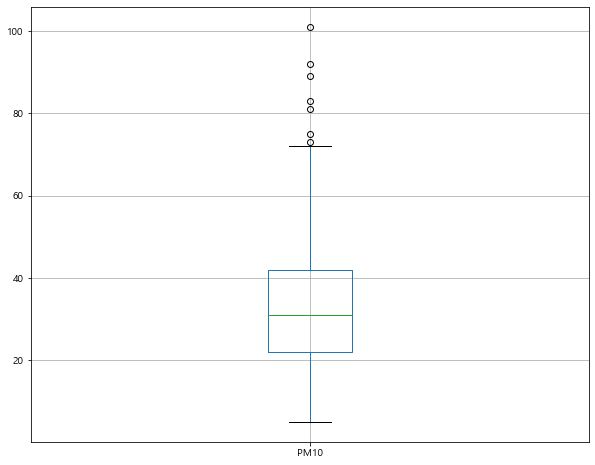

In [12]:
df_raw.boxplot(["PM10"], figsize = (10,8))

<AxesSubplot:>

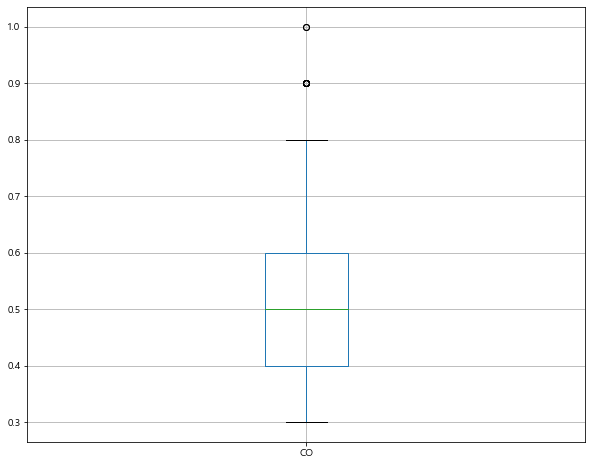

In [13]:
df_raw.boxplot(["CO"], figsize = (10,8))

<AxesSubplot:>

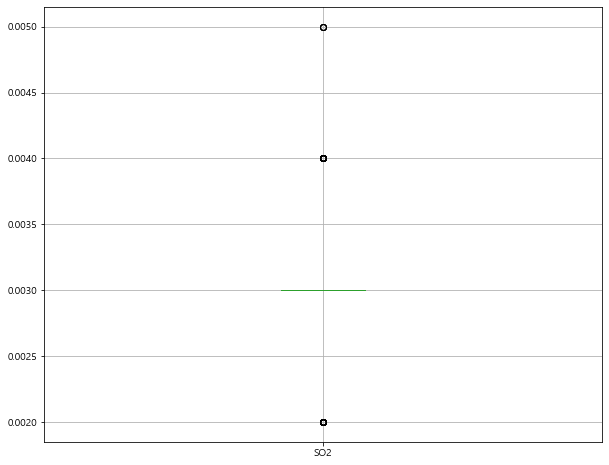

In [14]:
df_raw.boxplot(["SO2"], figsize = (10,8))

<AxesSubplot:>

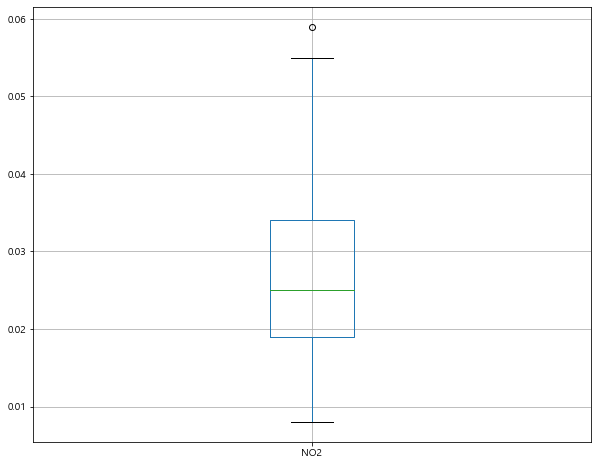

In [15]:
df_raw.boxplot(["NO2"], figsize = (10,8))

# 4. 그래프 분석

### 목표변수의 분포확인 

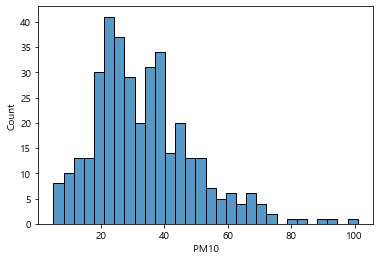

In [23]:
sns.histplot(df['PM10'],bins=30)

plt.show()

### 설명변수와 목표변수 간 관계확인

#### O3와 PM10의 관계

<AxesSubplot:xlabel='SO2', ylabel='PM10'>

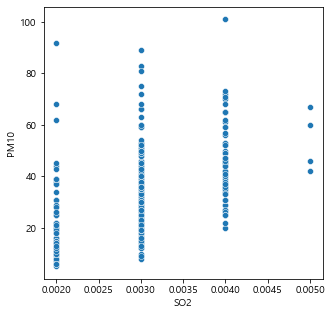

In [24]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = "SO2", y = "PM10", data = df_raw)


#### CO와 PM10의 관계

<AxesSubplot:xlabel='CO', ylabel='PM10'>

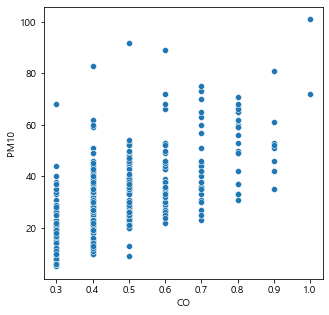

In [25]:
plt.figure(figsize = (5,5))

sns.scatterplot(x = "CO", y = "PM10", data = df_raw)

- CO가 증가할때 PM10도 같이 증가하는 모습을 볼 수 있다. 따라서 양의 상관관계를 보인다고 할 수 있다.  

#### NO2와 PM10의 관계

<AxesSubplot:xlabel='NO2', ylabel='PM10'>

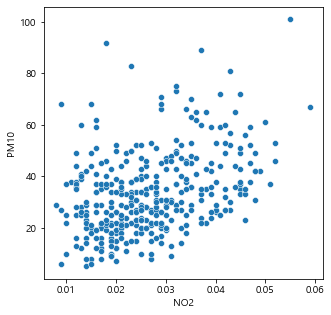

In [26]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = "NO2", y = "PM10", data = df_raw)

- NO2가 증가할때 PM10도 같이 증가하는 모습을 볼 수 있다. 상대적으로 넓게 분포하는 PM10을 보면 강한 선형관계를 유추하기를 어렵지만 전체적으로 우상향 그래프를 띈다고 볼 수 있을 것이다. 

#### TEMP와 PM10의 관계

<AxesSubplot:xlabel='TEMP', ylabel='PM10'>

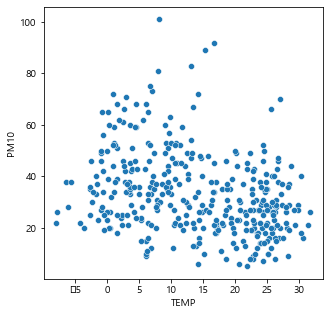

In [27]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = "TEMP", y = "PM10", data = df_raw)

- 명확한 선형성을 띄는 것은 아니지만 온도가 높아질 수록 PM10의 수치가 낮아지는 경향성, 온도가 높아지면 PM10의 수치가 높아지는 경향성을 보이는 것을 알 수 있다. 우리나라는 사계절이 있는 나라로서, 온도는 계절에 따라 변화하는 추이를 나타내기 때문에 추후 계절에 따른 수치의 변화가 있는지 확인 해볼 필요가 있다고 생각했다. 

#### ATM PRESS와 PM10의 관계

<AxesSubplot:xlabel='ATM_PRESS', ylabel='PM10'>

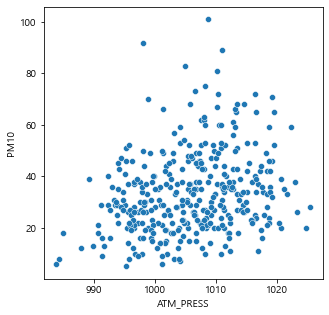

In [28]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = "ATM_PRESS", y = "PM10", data = df_raw)

- 기압을 나타내는 ATM_PRESS는 역시 뚜렷한 선형성을 찾아보기는 어렵지만 약한 선형성을 띈다고 할 수 있다. 과학적 지식에 따르면 겨울에는 내륙에 고기압이 형성되고, 여름에는 저기압이 형성된다. 겨울에서 봄 즈음 발생하는 고기압과 그로인해 발생하는 편서풍이 강해지면 우리나라의 서쪽에 위치하는 중국에서 발생하는 미세먼지 등이 우리나라에 영향을 주게 된다. 따라서 명확히 기압때문이라고 할수는 없지만, 바람 방향에 영향을 주는 기압임으로 , 본 관계를 보고 바람 방향이 주는 영향에 대해 정확히 분석해볼 필요가 있다고 판단했다.  

#### 기타요인과 PM10의 관계

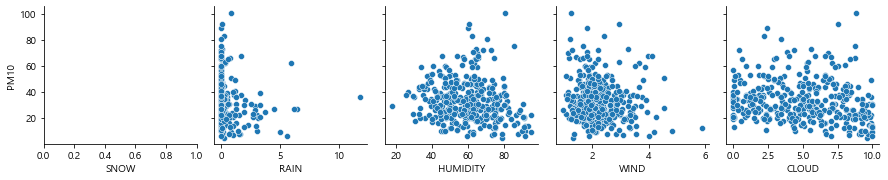

In [29]:
sns.pairplot(df_raw, y_vars = ["PM10"], x_vars = ["SNOW", "RAIN", "HUMIDITY", "WIND", "CLOUD"])

# 파생변수
- 계절별 파생변수
- 설명변수의 파생변수 : 평균보다 크거나, 작은 집단 생성
- 비/눈 이 오거나, 오지 않거나

### 계절별 파생변수 만들기

In [30]:
#날짜를 datetime 형태로 만들어주기

df_raw["MeasDate"] = pd.to_datetime(df_raw['MeasDate'])

In [31]:
# 년-월-일자 데이터에서 월만 뽑아오기 
df_raw['Month'] = df_raw['MeasDate'].dt.month

# #컬럼 재배열 
# df_raw = df_raw[['MeasDate','Month' ,'PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP', 'RAIN', 'WIND',
#        'WIND_DIR', 'HUMIDITY', 'ATM_PRESS', 'SNOW', 'CLOUD']]
# df_raw.head()

In [32]:
def season_var(month):
    if month ==3 or month ==4 or month == 5:
        return '봄'
    elif month ==6 or month ==7 or month == 8:
        return '여름'
    elif month ==9 or month ==10 or month == 11:
        return '가을'
    else:
        return '겨울'

    
#월별 데이터를 계절화하기 
df_raw['Season'] = df_raw['Month'].apply(season_var)
df_raw.head()


,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70,7,여름
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83,7,여름
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29,7,여름
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54,7,여름
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92,7,여름


In [33]:
df_raw.loc[10:10]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season
10,2019-07-11,5.0,0.023,0.014,0.3,0.002,21.79,0.23,1.3,204,79.0,995.2,0.0,9.63,7,여름


In [34]:
df_raw.loc[100:100]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season
100,2019-10-09,20.0,0.016,0.03,0.5,0.003,13.6,0.0,1.64,258,48.0,1009.7,0.0,2.13,10,가을


In [35]:
df_raw.loc[200:200]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season
200,2020-01-17,56.0,0.006,0.046,0.8,0.004,-0.64,0.0,1.51,200,44.0,1012.8,0.0,5.29,1,겨울


In [36]:
df_raw.loc[300:300]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season
300,2020-04-26,25.0,0.034,0.01,0.3,0.003,12.28,0.0,3.02,288,44.3,1006.5,0.0,1.54,4,봄


### 평균 이하 / 평균 이상 집단 구분하는 함수 생성

- 평균을 기준으로 높다면 1, 낮으면 0으로 인코딩한다. 



In [37]:
df_mean_list = list(df_raw.mean()) # 데이터프레임의 모든 컬럼의 평균을 리스트로 받음 
df_mean_list = df_mean_list[1:5] # 대기오염 컬럼만 슬라이싱으로 추출 O3, NO2, CO, SO2에 대해서만

def col_mean(df,mean_list):
    for idx ,values in enumerate(mean_list,start=1): #index 1부터 시작
        col_name = df.columns[idx+1] # 인덱스를 사용해 컬럼명 추출
        df[col_name+'_mean'] = '평균이하' #초기값 0, 새로운 컬럼 만들기 
        df.loc[df[col_name] >= values , col_name+'_mean'] = '평균이상' # 평균이상일 경우 해당 row 1로 값 변환 
    return df

col_mean(df_raw,df_mean_list)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season,O3_mean,NO2_mean,CO_mean,SO2_mean
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.00,2.30,249,63.2,995.1,0.0,5.70,7,여름,평균이상,평균이하,평균이상,평균이하
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.00,2.26,265,63.2,998.6,0.0,3.83,7,여름,평균이상,평균이하,평균이상,평균이하
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.00,1.79,280,65.3,998.3,0.0,6.29,7,여름,평균이상,평균이하,평균이하,평균이하
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.00,2.04,263,58.6,996.6,0.0,2.54,7,여름,평균이상,평균이하,평균이하,평균이하
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.00,1.45,175,45.5,993.5,0.0,3.92,7,여름,평균이상,평균이상,평균이상,평균이하
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73,6,여름,평균이상,평균이하,평균이하,평균이하
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21,6,여름,평균이상,평균이하,평균이하,평균이상
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63,6,여름,평균이상,평균이하,평균이하,평균이하
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,24.06,1.26,2.48,103,75.5,992.9,0.0,7.58,6,여름,평균이상,평균이상,평균이상,평균이하


### 비/눈 온날과 오지 않은 날
- 비의 양은 크게 중요하지 않다고 판단. 
- box plot의 용이성을 위해 한글로 우선 변환, 나중에 일괄 숫자 인코딩을 해주기로 한다. 

In [38]:
# 비가 온 날은 1, 비가 오지않은 날은 0으로 구분

df_raw["RAIN"] = np.where(df_raw["RAIN"] > 0, "비가 온 날", "비가 오지 않은 날")
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season,O3_mean,NO2_mean,CO_mean,SO2_mean
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,비가 오지 않은 날,2.30,249,63.2,995.1,0.0,5.70,7,여름,평균이상,평균이하,평균이상,평균이하
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,비가 오지 않은 날,2.26,265,63.2,998.6,0.0,3.83,7,여름,평균이상,평균이하,평균이상,평균이하
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,비가 오지 않은 날,1.79,280,65.3,998.3,0.0,6.29,7,여름,평균이상,평균이하,평균이하,평균이하
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,비가 오지 않은 날,2.04,263,58.6,996.6,0.0,2.54,7,여름,평균이상,평균이하,평균이하,평균이하
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,비가 오지 않은 날,1.45,175,45.5,993.5,0.0,3.92,7,여름,평균이상,평균이상,평균이상,평균이하


In [39]:
# 눈이 온 날은 1, 눈이 오지 않은 날은 0으로 구분

df_raw["SNOW"] = np.where(df_raw["SNOW"] > 0, "눈이 온 날", "눈이 오지 않은 날")
df_raw.head()


,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Season,O3_mean,NO2_mean,CO_mean,SO2_mean
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,비가 오지 않은 날,2.30,249,63.2,995.1,눈이 오지 않은 날,5.70,7,여름,평균이상,평균이하,평균이상,평균이하
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,비가 오지 않은 날,2.26,265,63.2,998.6,눈이 오지 않은 날,3.83,7,여름,평균이상,평균이하,평균이상,평균이하
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,비가 오지 않은 날,1.79,280,65.3,998.3,눈이 오지 않은 날,6.29,7,여름,평균이상,평균이하,평균이하,평균이하
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,비가 오지 않은 날,2.04,263,58.6,996.6,눈이 오지 않은 날,2.54,7,여름,평균이상,평균이하,평균이하,평균이하
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,비가 오지 않은 날,1.45,175,45.5,993.5,눈이 오지 않은 날,3.92,7,여름,평균이상,평균이상,평균이상,평균이하


### wind 방향에 따라 동, 서 남 북으로 나눈다.

In [40]:
df_raw['WIND_DIR_4'] = 0
df_raw['WIND_DIR_4'][(df_raw['WIND_DIR'] > 315) & (df_raw['WIND_DIR'] <= 360 )] = 'N'
df_raw['WIND_DIR_4'][(df_raw['WIND_DIR'] >= 0) & (df_raw['WIND_DIR'] <= 45 )] = 'N'                      
df_raw['WIND_DIR_4'][(df_raw['WIND_DIR'] > 45) & (df_raw['WIND_DIR'] <= 135)] = 'E'
df_raw['WIND_DIR_4'][(df_raw['WIND_DIR'] > 135) & (df_raw['WIND_DIR'] <= 225)] = 'S'
df_raw['WIND_DIR_4'][(df_raw['WIND_DIR'] > 225) & (df_raw['WIND_DIR'] <= 315)] = 'W'

df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,ATM_PRESS,SNOW,CLOUD,Month,Season,O3_mean,NO2_mean,CO_mean,SO2_mean,WIND_DIR_4
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,비가 오지 않은 날,2.30,249,...,995.1,눈이 오지 않은 날,5.70,7,여름,평균이상,평균이하,평균이상,평균이하,W
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,비가 오지 않은 날,2.26,265,...,998.6,눈이 오지 않은 날,3.83,7,여름,평균이상,평균이하,평균이상,평균이하,W
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,비가 오지 않은 날,1.79,280,...,998.3,눈이 오지 않은 날,6.29,7,여름,평균이상,평균이하,평균이하,평균이하,W
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,비가 오지 않은 날,2.04,263,...,996.6,눈이 오지 않은 날,2.54,7,여름,평균이상,평균이하,평균이하,평균이하,W
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,비가 오지 않은 날,1.45,175,...,993.5,눈이 오지 않은 날,3.92,7,여름,평균이상,평균이상,평균이상,평균이하,S


### 설명변수 파생변수와 목표변수 간의 분포차이 확인

<AxesSubplot:xlabel='Season', ylabel='PM10'>

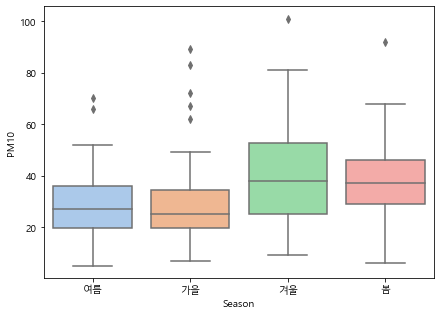

In [41]:
# 계절별 PM10의 분포

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "Season", y = "PM10", data = df_raw, palette='pastel')

<AxesSubplot:xlabel='RAIN', ylabel='PM10'>

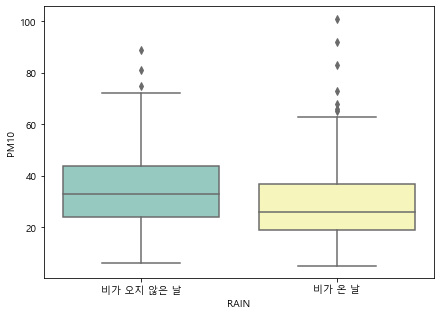

In [42]:
# 비가 오거나, 오지 않은 날의 PM10의 분포
# 0: 비가 오지 않은 날, 1: 비가 온 날

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "RAIN", y = "PM10", data = df_raw, palette='Set3')

<AxesSubplot:xlabel='SNOW', ylabel='PM10'>

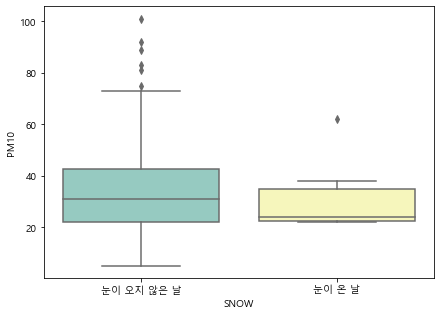

In [43]:
# 눈이 오거나, 오지 않은 날의 PM10의 분포
# 0: 눈이 오지 않은 날, 1: 눈이 온 날

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "SNOW", y = "PM10", data = df_raw, palette='Set3')

<AxesSubplot:xlabel='O3_mean', ylabel='PM10'>

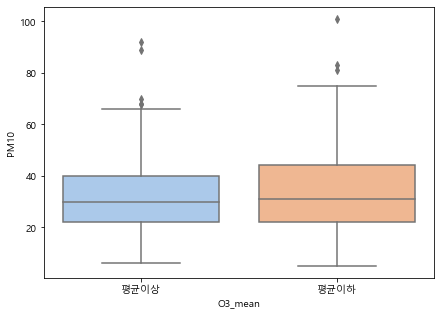

In [44]:
# 오존의 평균이상 평균이하 별 PM10분포

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "O3_mean", y = "PM10", data = df_raw, palette='pastel')

<AxesSubplot:xlabel='NO2_mean', ylabel='PM10'>

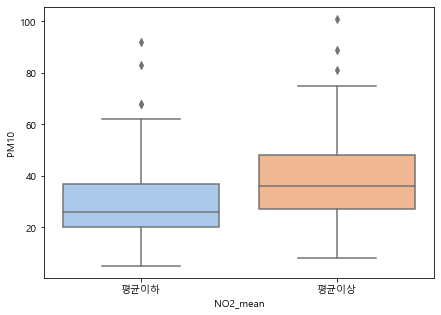

In [45]:
# NO2 평균이상 평균이하 별 PM10 분포

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "NO2_mean", y = "PM10", data = df_raw, palette='pastel')

<AxesSubplot:xlabel='CO_mean', ylabel='PM10'>

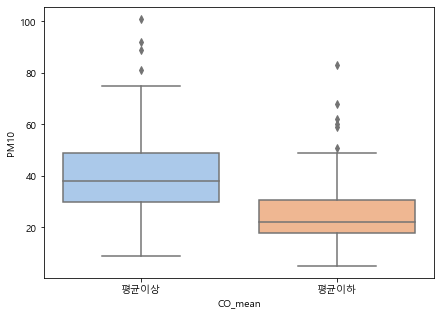

In [46]:
# CO 평균이상 평균이하 별 PM10 분포

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "CO_mean", y = "PM10", data = df_raw, palette='pastel')

<AxesSubplot:xlabel='SO2_mean', ylabel='PM10'>

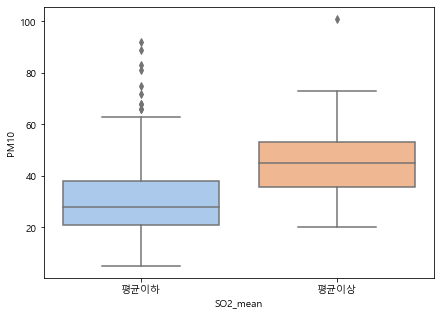

In [47]:
# SO2 평균이상 평균이하 별 PM10 분포

ax = plt.subplots(figsize = (7,5))
sns.boxplot(x = "SO2_mean", y = "PM10", data = df_raw, palette='pastel')

## 상관분석

- 목표변수와 연관있는 변수는 무엇인가? 

In [48]:
#상관관계를 관찰할 칼럼으로만 데이터프레임 추출
df_new = df_raw[['PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP', 'RAIN', 'WIND',
       'WIND_DIR', 'HUMIDITY', 'ATM_PRESS', 'SNOW', 'CLOUD']]
corr = df_new.corr(method = 'pearson')
corr

,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
PM10,1.000000,-0.051763,0.395969,0.629420,0.428685,-0.309786,-0.100323,0.019949,-0.149803,0.253023,-0.172230
O3,-0.051763,1.000000,-0.591658,-0.497763,-0.234127,0.516257,0.165216,0.268680,-0.037699,-0.534372,-0.119307
NO2,0.395969,-0.591658,1.000000,0.752197,0.563432,-0.237406,-0.536649,-0.408342,-0.065514,0.420292,0.016722
CO,0.629420,-0.497763,0.752197,1.000000,0.588514,-0.547358,-0.266187,-0.273337,-0.099831,0.518304,-0.083855
SO2,0.428685,-0.234127,0.563432,0.588514,1.000000,-0.273629,-0.252864,-0.093200,-0.302278,0.333995,-0.191234
TEMP,-0.309786,0.516257,-0.237406,-0.547358,-0.273629,1.000000,-0.216042,-0.050394,0.404147,-0.792079,0.341553
WIND,-0.100323,0.165216,-0.536649,-0.266187,-0.252864,-0.216042,1.000000,0.235237,-0.084299,-0.053769,0.016841
WIND_DIR,0.019949,0.268680,-0.408342,-0.273337,-0.093200,-0.050394,0.235237,1.000000,-0.098825,0.067591,-0.296964
HUMIDITY,-0.149803,-0.037699,-0.065514,-0.099831,-0.302278,0.404147,-0.084299,-0.098825,1.000000,-0.510358,0.627970
ATM_PRESS,0.253023,-0.534372,0.420292,0.518304,0.333995,-0.792079,-0.053769,0.067591,-0.510358,1.000000,-0.429744


#### 히트맵 시각화

<AxesSubplot:>

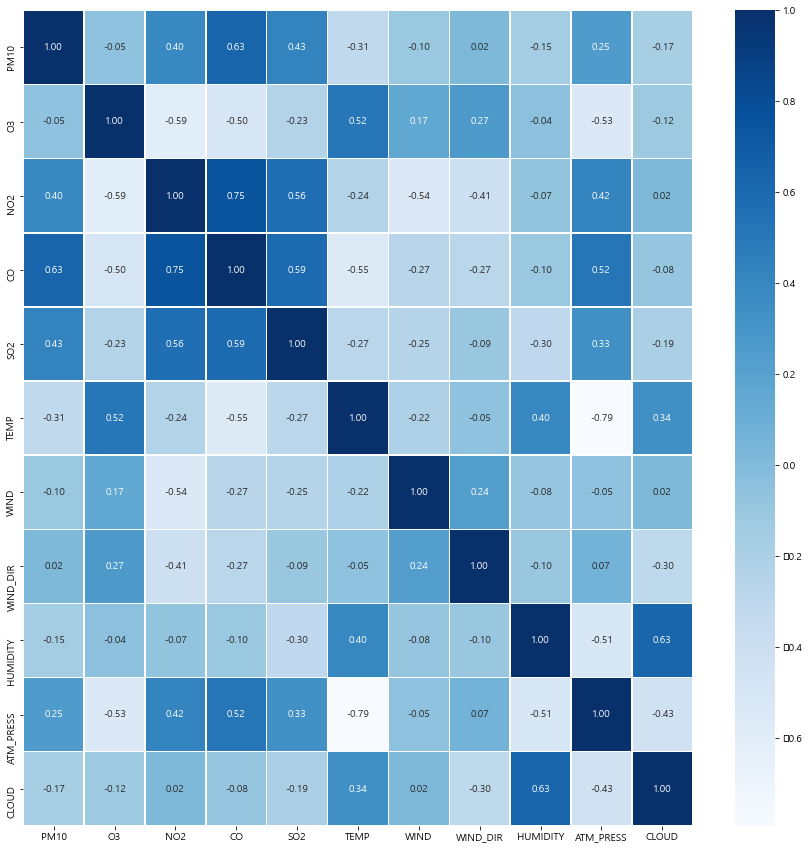

In [49]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_new.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

# 5. 통계적 가설검정
## 파생변수에 따른 목표변수의 차이 검정
    : 2-Sample t-test

### 평균보다 높은 집단 vs 평균보다 낮은집단 차이 검정
- 평균보다 높은 집단의 PM10과, 평균보다 낮은 집단의 PM10에 차이가 있는가? 를 검정하라는 건가?

- 그럼 평균이상 집단의 PM10을 모으고, 평균이하 집단의 PM10을 모으고? 

#### O3의 차이검정

In [50]:
# O3의 평균이상 1, 평균이하 1

df1 = df_raw[df_raw.O3_mean <= df_mean_list[0]]['PM10']
df2 = df_raw[df_raw.O3_mean > df_mean_list[0]]['PM10']

# df_raw["O3_mean"] = np.where(df_raw["O3_mean"] == "평균이상", 1, 0)
df_O3 = pd.concat([df1, df2], axis = 1, ignore_index = True)
df_O3

TypeError: '<=' not supported between instances of 'str' and 'float'

#### NO2의 차이검정

#### SO2의 차이검정

#### CO의 차이검정

### 비가 오는 경우 vs 비가 오지 않는 경우
- 비가 오는 경우의 PM10과 비가 오지않는 경우의 PM10 의 차이 검정

In [51]:
# df_raw에서 RAIN이 '비가 오지 않는 날'일 경우의 PM10

df1 = df_raw[df_raw.RAIN == "비가 오지 않은 날"]['PM10']
df2 = df_raw[df_raw.RAIN == "비가 온 날"]['PM10']

df1 = df1.dropna()
df2 = df2.dropna()


statistic, p = stats.shapiro(df1)
print("statistic ={}, p-value = {}".format(statistic, p))

statistic, p = stats.shapiro(df2)
print("statistic ={}, p-value = {}".format(statistic, p))

statistic =0.9625291228294373, p-value = 3.7925456126686186e-06
statistic =0.8876467347145081, p-value = 9.800134392889959e-08


 - 비가 온 날과 오지 않은 날은 정규성을 만족하지 않는다. 따라서 t test 불가함.   
     비 같은 경우에는 미세먼지 저감에 효과가 있는것으로 알려져있으나, 관련 자료에 의하면 강수량이 시간당 10mm이상은 되어야 효과가 있다고 한다. 이번에 폭우로 문제가 되었던 서울 폭우량은 시간당 36mm였다. 하지만 이러한 강우량은 100년에 한번 올까말까 한 양으로서, 비가 미세먼지 증가나 감소에 효과적인 역할을 한다고 볼 수 없다고 판단, 모델링 시 해당 변수를 삭제하기로 한다. 

### 눈이 오는 경우 vs 눈이 오지 않는 경우
- 눈가 오는 경우의 PM10과 눈가 오지않는 경우의 PM10 의 차이 검정

In [52]:
# df_raw에서 snow가 '눈이 오지 않는 날'일 경우의 PM10

df3 = df_raw[df_raw.SNOW == "눈이 오지 않은 날"]['PM10']
df4 = df_raw[df_raw.SNOW == "눈이 온 날"]['PM10']

df3 = df3.dropna()
df4 = df4.dropna()

df_snow = pd.concat([df3, df4], axis = 1, ignore_index = True)
df_snow.columns = ['snow', 'no_snow']
df_snow.isnull().sum()
df_snow

,snow,no_snow
0,29.0,NaN
1,26.0,NaN
2,30.0,NaN
3,28.0,NaN
4,29.0,NaN
...,...,...
361,19.0,NaN
362,22.0,NaN
363,27.0,NaN
364,36.0,NaN


In [53]:
statistic, p = stats.shapiro(df3)
print("statistic ={}, p-value = {}".format(statistic, p))

statistic, p = stats.shapiro(df4)
print("statistic ={}, p-value = {}".format(statistic, p))


statistic =0.9501688480377197, p-value = 1.1793275245253199e-09
statistic =0.7293481826782227, p-value = 0.01241486705839634


- 눈이 온 날과 오지 않은 날은 정규성을 만족하지 않는다. 따라서 t-test 불가함. 
    눈이 온 날은 일년의 데이터 중 딱 6일이다. 너무 적은 데이터를 가지고 있으므로 유의미한 분석이 불가하다고 판단, 모델링 시 삭제 하기로 한다. 

# 6. 모델링 및 평가

#### 모델링 기본

In [54]:
# 범주형 변수에 대해서 더미변수 생성

df = pd.get_dummies(df_raw)
df.columns

Index(['MeasDate', 'PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP', 'WIND',
       'WIND_DIR', 'HUMIDITY', 'ATM_PRESS', 'CLOUD', 'Month',
       'RAIN_비가 오지 않은 날', 'RAIN_비가 온 날', 'SNOW_눈이 오지 않은 날', 'SNOW_눈이 온 날',
       'Season_가을', 'Season_겨울', 'Season_봄', 'Season_여름', 'O3_mean_평균이상',
       'O3_mean_평균이하', 'NO2_mean_평균이상', 'NO2_mean_평균이하', 'CO_mean_평균이상',
       'CO_mean_평균이하', 'SO2_mean_평균이상', 'SO2_mean_평균이하', 'WIND_DIR_4_E',
       'WIND_DIR_4_N', 'WIND_DIR_4_S', 'WIND_DIR_4_W'],
      dtype='object')

In [55]:
#모델링에 필요없는 데이터 칼럼 제거
df = df.drop(columns = ['MeasDate','Month','WIND_DIR', 'RAIN_비가 오지 않은 날', 'RAIN_비가 온 날', 'SNOW_눈이 오지 않은 날', 'SNOW_눈이 온 날','O3_mean_평균이상',
       'O3_mean_평균이하', 'NO2_mean_평균이상', 'NO2_mean_평균이하', 'CO_mean_평균이상',
       'CO_mean_평균이하', 'SO2_mean_평균이상', 'SO2_mean_평균이하'], axis = 1)
df.head()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,Season_가을,Season_겨울,Season_봄,Season_여름,WIND_DIR_4_E,WIND_DIR_4_N,WIND_DIR_4_S,WIND_DIR_4_W
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,0,0,0,1,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,0,0,0,1,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,0,0,0,1,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,0,0,0,1,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,0,0,0,1,0,0,1,0


#### 데이터 스케일링

In [57]:
#스탠다드 스케일러

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled.head()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,Season_가을,Season_겨울,Season_봄,Season_여름,WIND_DIR_4_E,WIND_DIR_4_N,WIND_DIR_4_S,WIND_DIR_4_W
0,-0.277826,2.558984,-0.566824,0.093862,-0.052053,1.035373,0.105769,0.204900,-1.325967,0.216196,-0.576296,-0.576296,-0.576296,1.722612,-0.456738,-0.149696,-0.734904,1.094895
1,-0.466314,2.474806,-0.664322,0.093862,-0.052053,1.061826,0.050401,0.204900,-0.894922,-0.410992,-0.576296,-0.576296,-0.576296,1.722612,-0.456738,-0.149696,-0.734904,1.094895
2,-0.214997,1.548858,-0.371828,-0.529038,-0.052053,1.050634,-0.600182,0.349878,-0.931868,0.414079,-0.576296,-0.576296,-0.576296,1.722612,-0.456738,-0.149696,-0.734904,1.094895
3,-0.340655,0.875442,-0.079334,-0.529038,-0.052053,1.169676,-0.254127,-0.112673,-1.141233,-0.843651,-0.576296,-0.576296,-0.576296,1.722612,-0.456738,-0.149696,-0.734904,1.094895
4,-0.277826,1.801390,0.798148,0.093862,-0.052053,1.368080,-1.070816,-1.017064,-1.523017,-0.380806,-0.576296,-0.576296,-0.576296,1.722612,-0.456738,-0.149696,1.360721,-0.913330


#### 설명변수와 독립변수

In [61]:
# 종속변수와 독립변수 분리
df_y = df["PM10"]
df_x = df.drop(columns = ["PM10"], inplace = False)
df_scaled_y = df_scaled["PM10"]
df_scaled_x = df_scaled.drop(columns = ["PM10"], inplace = False)

In [64]:
# 변수 간의 경향성 파악 및 다중공선성 확인
# 다중 공선성이 있는 변수들이 보임 (EX. NO2, CO)
df_scaled.corr()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,Season_가을,Season_겨울,Season_봄,Season_여름,WIND_DIR_4_E,WIND_DIR_4_N,WIND_DIR_4_S,WIND_DIR_4_W
PM10,1.000000,-0.051763,0.395969,0.629420,0.428685,-0.309786,-0.100323,-0.149803,0.253023,-0.172230,-0.203082,0.258076,0.149849,-0.204098,-0.120972,-0.176791,0.085852,0.061519
O3,-0.051763,1.000000,-0.591658,-0.497763,-0.234127,0.516257,0.165216,-0.037699,-0.534372,-0.119307,-0.251937,-0.459308,0.241168,0.468370,-0.240934,-0.021737,-0.058866,0.245650
NO2,0.395969,-0.591658,1.000000,0.752197,0.563432,-0.237406,-0.536649,-0.065514,0.420292,0.016722,0.233984,0.263004,-0.245773,-0.250303,0.230244,-0.092149,0.213750,-0.352476
CO,0.629420,-0.497763,0.752197,1.000000,0.588514,-0.547358,-0.266187,-0.099831,0.518304,-0.083855,-0.005080,0.519575,-0.135257,-0.377862,0.173831,-0.149129,0.083285,-0.167885
SO2,0.428685,-0.234127,0.563432,0.588514,1.000000,-0.273629,-0.252864,-0.302278,0.333995,-0.191234,0.060243,0.250752,-0.150319,-0.160093,-0.000818,-0.126298,0.098101,-0.056253
TEMP,-0.309786,0.516257,-0.237406,-0.547358,-0.273629,1.000000,-0.216042,0.404147,-0.792079,0.341553,0.099910,-0.703718,-0.096468,0.697734,-0.028639,0.069584,0.099362,-0.093944
WIND,-0.100323,0.165216,-0.536649,-0.266187,-0.252864,-0.216042,1.000000,-0.084299,-0.053769,0.016841,-0.054408,-0.015574,0.320958,-0.250065,-0.036690,0.140161,-0.287850,0.262478
HUMIDITY,-0.149803,-0.037699,-0.065514,-0.099831,-0.302278,0.404147,-0.084299,1.000000,-0.510358,0.627970,0.036193,-0.128372,-0.235138,0.326129,0.017959,0.067619,0.087796,-0.117645
ATM_PRESS,0.253023,-0.534372,0.420292,0.518304,0.333995,-0.792079,-0.053769,-0.510358,1.000000,-0.429744,0.189011,0.570556,-0.084201,-0.672915,-0.014548,-0.009754,-0.073411,0.084259
CLOUD,-0.172230,-0.119307,0.016722,-0.083855,-0.191234,0.341553,0.016841,0.627970,-0.429744,1.000000,0.002929,-0.082712,-0.161174,0.240082,0.211301,0.070961,0.105235,-0.282071


---

## 6-1. 다중회귀분석 모델

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [66]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size = 0.3, random_state = 1234)
print("train data size : {}".format(df_scaled_train.shape))
print("test data size : {}".format(df_scaled_test.shape))

train data size : (255, 18)
test data size : (110, 18)


#### 회귀모델 설정

In [67]:
reg_model = smf.ols(formula = "PM10 ~ O3 + NO2 + CO + TEMP + WIND + Season_가을 + Season_봄 + WIND_DIR_4_E  + WIND_DIR_4_S + WIND_DIR_4_W", data = df_scaled_train)

reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     32.50
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           1.50e-39
Time:                        23:08:49   Log-Likelihood:                -252.08
No. Observations:                 255   AIC:                             526.2
Df Residuals:                     244   BIC:                             565.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0150      0.042     -0.358   

- 분산분석 결과 p값이 유의수준 0.05보다 작고, 더빈왓슨 값이 2에 가까운 값으로 독립성을 보인다고도 할 수 있을 것 같다. 몇몇 변수의 p값이 0.05보다 작으므로 유의할 수도 있다고 판단, 추가로 변수간의 다중공선성 및 잔차의 기본전제를 만족하는지 확인을 해봐야할 것 같다. 

#### 잔차의 기본전제 확인

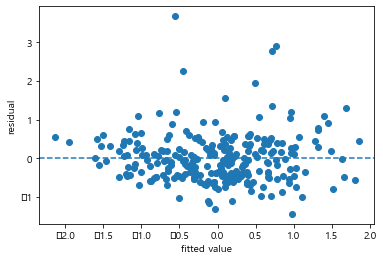

In [68]:
#등분산성 검정

plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y=0, linestyle = "--")

- 잔차가 y=0을 기준으로 위쪽으로 더 튀어있는 값들이 보인다. 따라서 등분산되어 있지 않다는 것을 그래프로 확인 할 수 있다. 

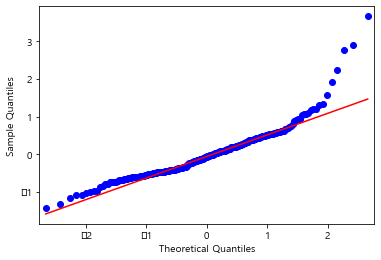

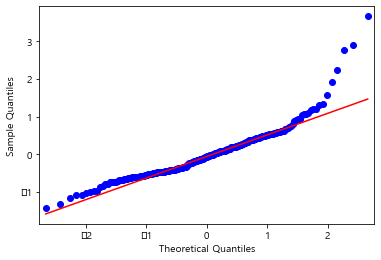

In [69]:
# 정규성 검정 
qqplot(reg_result.resid, line = 'q')

- 정규분포 직선을 중심으로, 위 쪽으로 많이 튀어있는 값들이 있기에 정규분포를 따른다고 할 수 없다. 

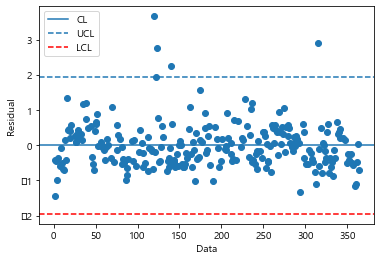

In [70]:
# 독립성 검정

plt.scatter(df_scaled_train.index, reg_result.resid)
plt.xlabel("Data"); plt.ylabel("Residual")
plt.axhline(y=0, linestyle = "-", label = 'CL')
plt.axhline(y=3*np.std(reg_result.resid), linestyle = "--", label = 'UCL')
plt.axhline(y=-3*np.std(reg_result.resid), linestyle = "dashed", color = 'red',label = 'LCL')
plt.legend()


- 독립성 역시 상한선을 넘어서 까지 데이터가 튀어있는 모습을 보여, 만족하지 않는다고 할 수 있다. 

### 결론

- 다중선형회귀분석은 잔차의 기본 전제를 만족하지 못하기 때문에 유의미한 모델이라고 할 수 없다. 따라서 다른 모델을 사용하는 것으로 한다. 

---

## 6-2. 의사결정나무 모델

In [71]:
# 데이터 분할

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (255, 17)
train data Y size : (255,)
test data X size : (110, 17)
test data Y size : (110,)


#### 기본 모델 만들기

In [72]:
# 기본 모델 만들기

tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.059


- train data에 과적합, test데이터에 너무 낮은 성능을 보인다. 따라서 하이퍼 파라미터의 조정이 필수적이라고 할 수 있다. 

#### 리프노드 수 조정

In [74]:
train_score = []; test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampleLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,1.000,0.059
1,2,0.940,0.194
2,3,0.859,0.434
3,4,0.807,0.385
4,5,0.755,0.431
5,6,0.732,0.391
6,7,0.704,0.405
7,8,0.675,0.375
8,9,0.656,0.389
9,10,0.640,0.407


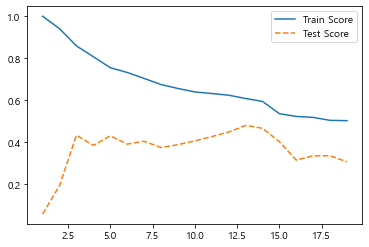

In [75]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.legend()

- 과적합방지 및 train과 test간의 간격이 가장 최소가 되는 14가 최적의 리프노드수라고 판단.

#### 스플릿노드 수 조정

In [76]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(2,20)]
for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=14, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSampleSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSampleSplit,TrainScore,TestScore
0,4,0.595,0.467
1,6,0.595,0.467
2,8,0.595,0.467
3,10,0.595,0.467
4,12,0.595,0.467
5,14,0.595,0.467
6,16,0.595,0.467
7,18,0.595,0.467
8,20,0.595,0.467
9,22,0.595,0.467


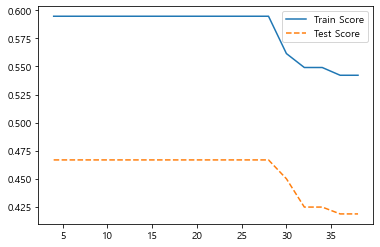

In [77]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()

#### 최대 깊이 조절

In [78]:
train_score = []; test_score=[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234,min_samples_leaf=14, min_samples_split=26, max_depth=v_max_depth)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.257,0.221
1,2,0.355,0.311
2,3,0.469,0.376
3,4,0.543,0.449
4,5,0.595,0.467
5,6,0.595,0.467
6,7,0.595,0.467
7,8,0.595,0.467
8,9,0.595,0.467
9,10,0.595,0.467


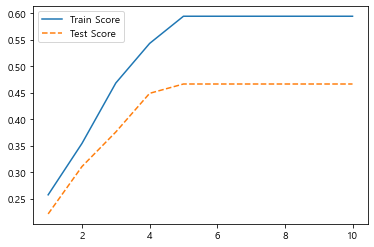

In [79]:
df_score_depth.round(3)
plt.plot(para_depth, train_score, linestyle="-",label="Train Score")
plt.plot(para_depth, test_score, linestyle="--",label="Test Score")
plt.legend()

#### 최종모델

In [80]:
# 최종모델
tree_final = DecisionTreeRegressor(min_samples_leaf=14, min_samples_split=26, max_depth=5,random_state=1234)
tree_final.fit(df_train_x, df_train_y)


print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.595
Score on test set: 0.467


- 초기모델에 비해 많이 학습된 모습을 보이는 것을 알 수 있다. train data도 과적합에서 벗어났고, test데이터도 어느정도의 학습률을 보인다. 하지만 예측성능이 0.46정도로, 50%를 채 넘지 못함으로 유의미한 모델이라고 보기 어렵다. 따라서 다른 모델을 사용한다. 

#### 변수 중요도

In [81]:
# 설명변수의 중요도
df_importance = pd.DataFrame()
df_importance["Feature"]=df_x.columns
df_importance["Importance"]=tree_final.feature_importances_
df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.569
0,O3,0.170
8,CLOUD,0.084
11,Season_봄,0.083
5,WIND,0.073
6,HUMIDITY,0.011
4,TEMP,0.010
3,SO2,0.000
7,ATM_PRESS,0.000
1,NO2,0.000


Text(0, 0.5, '변수 ')

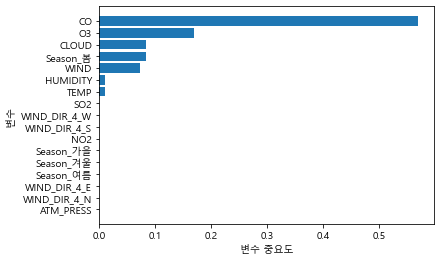

In [82]:
# 설명변수 중요도 그래프

df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width =df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수 ")

## 결론

- 상관계수가 가장 높게 나왔던 CO가 역시나 변수 중요도에서도 가장 높은 점수를 가진다. 그 다음으로는 O3가 중요도 가 높게 나왔는데, 이 두가지 인자는 대기오염인자로서 미세먼지 발생에 유의미한 영향을 미친다고 할 수 있을것이다. 
- 하지만 해당 의사결정나무 모델의 정확도는 낮기때문에 다른 변수들까지도 유의미한 인자인지는 신뢰성이 조금 떨어지기 때문에, 다른 모델로 좀 더 탐구해보기로 한다. 

---

## 6-3. 랜덤포레스트

#### 초기모델 생성

In [83]:
#초기모델 생성

rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.924
Score on test set: 0.515


- 의사결정나무보다는 초기모델에 대해서 더 좋은 성능을 보이는 것을 확인 할 수 있으나 역시 train data에 대해서 과적합 경향을 보이고있다. 

In [84]:
df_scaled_train_x, df_scaled_test_x, df_scaled_train_y, df_scaled_test_y = train_test_split(df_scaled_x, df_scaled_y, test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_scaled_train_x.shape))
print("train data Y size : {}".format(df_scaled_train_y.shape))
print("test data X size : {}".format(df_scaled_test_x.shape))
print("test data Y size : {}".format(df_scaled_test_y.shape))

train data X size : (255, 17)
train data Y size : (255,)
test data X size : (110, 17)
test data Y size : (110,)


#### 트리 수 조정

In [85]:
train_score=[]
test_score=[]
para_n_tree = [n_tree * 10 for n_tree in range(1, 21)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(rf.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(rf.score(df_scaled_test_x, df_scaled_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.889,0.490
1,20,0.902,0.517
2,30,0.910,0.506
3,40,0.912,0.502
4,50,0.918,0.501
5,60,0.923,0.504
6,70,0.926,0.503
7,80,0.925,0.518
8,90,0.925,0.517
9,100,0.925,0.517


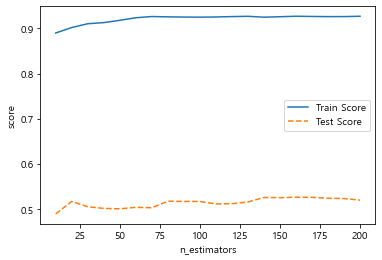

In [86]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

#### 리프노드 조정

In [87]:
train_score = []
test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 25, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(rf.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(rf.score(df_scaled_test_x, df_scaled_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.907,0.506
1,2,0.855,0.527
2,3,0.809,0.540
3,4,0.772,0.519
4,5,0.739,0.527
5,6,0.710,0.514
6,7,0.689,0.497
7,8,0.670,0.480
8,9,0.647,0.476
9,10,0.634,0.456


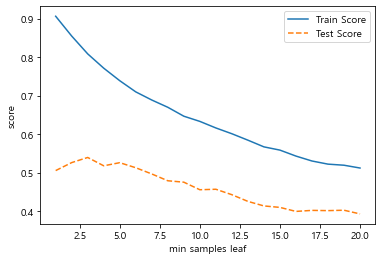

In [88]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

#### 스플릿노드 조정

In [89]:
train_score = []; test_score=[]
para_split = [n_split*3 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 25, min_samples_leaf=3, min_samples_split = v_min_samples_split )
    
    rf.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(rf.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(rf.score(df_scaled_test_x, df_scaled_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplessplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score
df_score_split.round(3)

,MinSamplessplit,TrainScore,TestScore
0,6,0.809,0.540
1,9,0.780,0.528
2,12,0.749,0.512
3,15,0.720,0.499
4,18,0.700,0.492
5,21,0.684,0.486
6,24,0.656,0.482
7,27,0.640,0.473
8,30,0.619,0.456
9,33,0.603,0.451


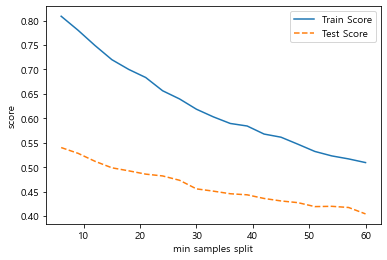

In [90]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

#### 최대 깊이 조정

In [91]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 25, min_samples_leaf = 3, min_samples_split = 5, max_depth = v_max_depth)
    rf.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(rf.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(rf.score(df_scaled_test_x, df_scaled_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.290,0.277
1,2,0.439,0.380
2,3,0.576,0.464
3,4,0.666,0.509
4,5,0.735,0.520
5,6,0.773,0.529
6,7,0.794,0.533
7,8,0.803,0.538
8,9,0.807,0.540
9,10,0.808,0.540


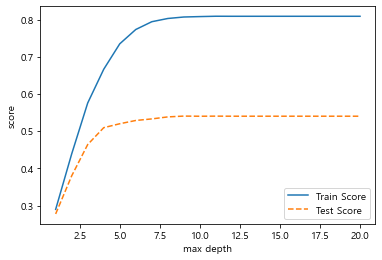

In [92]:
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

#### 최종모델 

In [93]:
#최종모델

rf_final = RandomForestRegressor(random_state=1234, n_estimators = 25, min_samples_leaf = 3, min_samples_split = 5, max_depth = 6)
rf_final.fit(df_scaled_train_x, df_scaled_train_y)
print("Score on training set: {:.3f}".format(rf_final.score(df_scaled_train_x, df_scaled_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_scaled_test_x, df_scaled_test_y)))

Score on training set: 0.773
Score on test set: 0.529


- 초기모델에 비해 과적합이 많이 낮아지고, test score가 많이 상승한 것을 확인 할 수 있다. 이전 모델인 디시전트리보다 나은 모델 정확도를 보이고 있다. 

#### 변수 중요도

In [94]:
# 설명변수의 중요도
df_importance = pd.DataFrame()
df_importance["Feature"]=df_scaled_train_x.columns
df_importance["Importance"]=rf_final.feature_importances_
df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.417
0,O3,0.144
8,CLOUD,0.094
5,WIND,0.090
1,NO2,0.047
6,HUMIDITY,0.047
4,TEMP,0.040
7,ATM_PRESS,0.040
11,Season_봄,0.024
9,Season_가을,0.020


Text(0, 0.5, '변수')

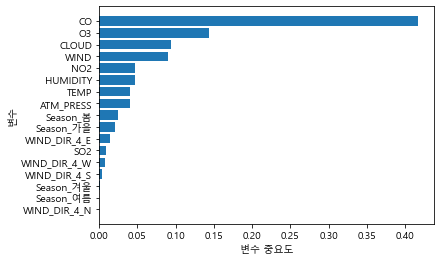

In [95]:
#그래프로 확인

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 결론

- 이전의 의사결정나무 모델과 같이 가장 중요도가 높은 변수는 CO와 O3였다. 그 다음은 구름의 양과 바람의 세기 또한 중요변수로 확인할 수 있었다. 

---

## 6-4.그래디언트 부스팅

#### 기본모델 생성

In [96]:
df_scaled_train_x, df_scaled_test_x, df_scaled_train_y, df_scaled_test_y = train_test_split(df_scaled_x, df_scaled_y, test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_scaled_train_x.shape))
print("train data Y size : {}".format(df_scaled_train_y.shape))
print("test data X size : {}".format(df_scaled_test_x.shape))
print("test data Y size : {}".format(df_scaled_test_y.shape))

train data X size : (255, 17)
train data Y size : (255,)
test data X size : (110, 17)
test data Y size : (110,)


In [97]:
# 그래디언트 부스팅 기본 옵션으로 모델 생성
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_scaled_train_x, df_scaled_train_y)

print('Score on training set: {:.3f}'.format(gb_uncustomized.score(df_scaled_train_x, df_scaled_train_y)))
print('Score on test set: {:.3f}'.format(gb_uncustomized.score(df_scaled_test_x, df_scaled_test_y)))

Score on training set: 0.929
Score on test set: 0.510


#### 트리수 변경

In [98]:
# n_estimators: 트리 수 변경에 따른 모델 생성

#train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]  # * 참조: para_leaf: [10,20,30,...,100]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(gb.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(gb.score(df_scaled_test_x, df_scaled_test_y))
    
# 결과 저장
df_score_n = pd.DataFrame()
df_score_n['Estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.526,0.427
1,20,0.683,0.511
2,30,0.764,0.548
3,40,0.813,0.556
4,50,0.846,0.549
5,60,0.875,0.535
6,70,0.892,0.530
7,80,0.903,0.524
8,90,0.916,0.521
9,100,0.929,0.510


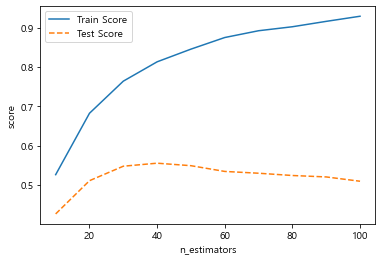

In [99]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle='--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend()

#### 리프노드 수 조절

In [100]:
# min_samples_leaf:잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

#train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]  # * 참조: para_leaf: [1,2,3,...,20]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=30,
                                  min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(rf.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(rf.score(df_scaled_test_x, df_scaled_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.809,0.54
1,2,0.809,0.54
2,3,0.809,0.54
3,4,0.809,0.54
4,5,0.809,0.54
5,6,0.809,0.54
6,7,0.809,0.54
7,8,0.809,0.54
8,9,0.809,0.54
9,10,0.809,0.54


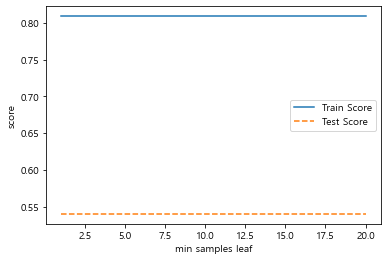

In [101]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle='--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()

#### 스플릿 노드 수 조절

In [102]:
# min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

#train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_split = [n_split * 2 for n_split in range(1, 21)]  # * 참조: para_leaf: [1,2,3,...,20]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf = 10,
                                  min_samples_split = v_min_samples_split)
    gb.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(gb.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(gb.score(df_scaled_test_x, df_scaled_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.720,0.529
1,4,0.720,0.529
2,6,0.720,0.529
3,8,0.720,0.529
4,10,0.720,0.529
5,12,0.720,0.529
6,14,0.720,0.529
7,16,0.720,0.529
8,18,0.720,0.529
9,20,0.720,0.529


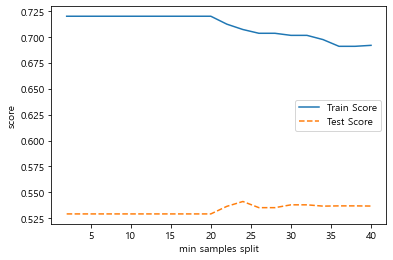

In [103]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle='--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min samples split')
plt.legend()

#### 최대 깊이 조절

In [104]:
# max_depth: 최대 깊이 변경에 따른 모델 성능

#train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_depth = [depth for depth in range(1, 21)]  # * 참조: para_depth: [1,2,3,...,10]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf = 10,
                                  min_samples_split = 24, max_depth = v_max_depth)
    gb.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(gb.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(gb.score(df_scaled_test_x, df_scaled_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

df_score_depth.round(3)

,depth,TrainScore,TestScore
0,1,0.398,0.375
1,2,0.599,0.515
2,3,0.707,0.541
3,4,0.791,0.507
4,5,0.830,0.505
5,6,0.849,0.500
6,7,0.854,0.507
7,8,0.861,0.491
8,9,0.861,0.501
9,10,0.861,0.501


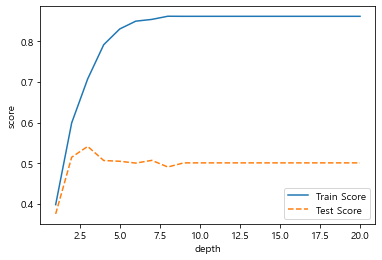

In [105]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle='--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('depth')
plt.legend()

#### 학습률에 따른 변경

In [106]:
#train 및 test 설명력 결과 저장
train_score = []; test_score = []
# learning rate: 학습률 변경에 따른 모델 성능
para_lr = [lr * 0.1 for lr in range(1, 10)]  # * 참조: para_depth: [0.1,0.2,0.3,...,0.9]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf = 10,
                                  min_samples_split = 24, max_depth = 3, learning_rate = v_learning_rate)
    gb.fit(df_scaled_train_x, df_scaled_train_y)
    train_score.append(gb.score(df_scaled_train_x, df_scaled_train_y))
    test_score.append(gb.score(df_scaled_test_x, df_scaled_test_y))
    
# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['TestScore'] = test_score

df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.707,0.541
1,0.2,0.815,0.517
2,0.3,0.874,0.512
3,0.4,0.899,0.510
4,0.5,0.919,0.482
5,0.6,0.941,0.436
6,0.7,0.940,0.442
7,0.8,0.957,0.367
8,0.9,0.960,0.365


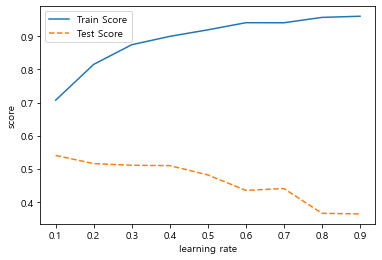

In [107]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_lr, test_score, linestyle='--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('learning rate')
plt.legend()


#### 최종 모델 

In [121]:
# 결론 도출 - 최종 모델 선택
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf = 10,
                                  min_samples_split = 24, max_depth = 3, learning_rate = 0.1)
gb_final.fit(df_scaled_train_x, df_scaled_train_y)

print('Score on training set: {:.3f}'.format(gb_final.score(df_scaled_train_x, df_scaled_train_y)))
print('Score on test set: {:.3f}'.format(gb_final.score(df_scaled_test_x, df_scaled_test_y)))

Score on training set: 0.707
Score on test set: 0.541


#### 변수 중요도

In [122]:
# feature_importances_: 설명변수의 중요도
# 변수명 저장
v_feature_name = df_scaled_train_x.columns

#tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.500
0,O3,0.149
11,Season_봄,0.063
8,CLOUD,0.058
6,HUMIDITY,0.056
4,TEMP,0.056
5,WIND,0.025
7,ATM_PRESS,0.025
16,WIND_DIR_4_W,0.022
13,WIND_DIR_4_E,0.013


Text(0, 0.5, '변수')

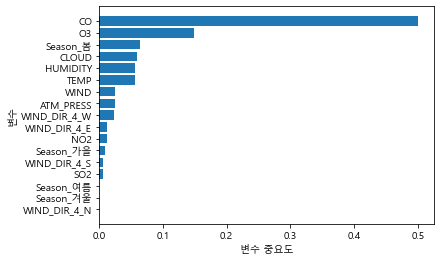

In [123]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values('Importance',ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

---
# 7. 모델 평가

#### 평가함수 정의

In [124]:
def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100 

models = ['DT','RF','GD']
mse,rmse,mae,mape =[],[],[],[]


#### 예측 및 평가

In [145]:
#의사결정나무

dt_y_pred = tree_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y,dt_y_pred))
mae.append(mean_absolute_error(df_test_y,dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,dt_y_pred))

In [154]:
# 랜덤포레스트

rf_y_pred = rf_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y,rf_y_pred))
mae.append(mean_absolute_error(df_test_y,rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,rf_y_pred))

In [157]:
# 그래디언트 부스팅

gb_y_pred = gb_final.predict(df_test_x)


mse.append(mean_squared_error(df_test_y,gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y,gb_y_pred))
mae.append(mean_absolute_error(df_test_y,gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,gb_y_pred))

#### 시각화

ValueError: shape mismatch: objects cannot be broadcast to a single shape

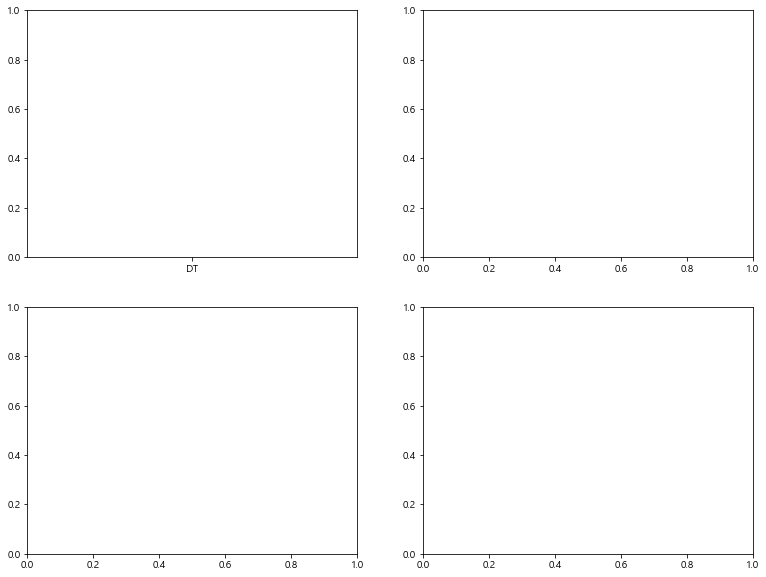

In [158]:
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0, 0].bar(models, mse)
ax[0, 0].set_title("mse").set_fontsize(15)

ax[0, 1].bar(models, rmse)
ax[0, 1].set_title("rmse").set_fontsize(15)

ax[1, 0].bar(models, mae)
ax[1, 0].set_title("mae").set_fontsize(15)

ax[1, 1].bar(models, mape)
ax[1, 1].set_title("mape").set_fontsize(15)

---

# 8. 최종 결론

- 미세먼지에 영향을 주는 인자는 일산화탄소, 오존, 계절 중 봄, 온도, 구름의 양, 서풍 등이 있다. 세가지 모델링을 진행했고 그 중 가장 정확도가 높았던 것은 그래디언트 부스팅 모델로 test 스코어가 0.541로서 높은 정확도는 아니지만 미세먼지라는 특성상 뚜렷한 인자에 의해 정확한 선형관계를 나타내거나 영향인자의 개수가 적은 타겟은 아님으로 어느정도 유의미한 모델이라고 할수 있다. 

- 이러한 인자들을 통해서 미세먼지 저감을 위해 어떤 대책을 세워야 할지 더 고민해서 PPT에 작성하고자 한다. 